In [1]:
from __future__ import print_function
import os
import numpy as np
import glob
from PIL import Image  
from random import *  
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import pandas as pd
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from tensorflow.keras.layers import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow
import tensorflow.keras
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

In [2]:
# fix random seed for reproducibility
np.random.seed(10)

In [3]:
#Use the dataset1.csv dataset1
dataframe = pd.read_csv('dataset1/train1.csv', usecols=[1], engine='python', skipfooter=3)
dataset1   = dataframe.values
dataset1   = dataset1.astype('float32')
dataframe.head()

,Water Level
0,2.42
1,2.40
2,2.37
3,2.34
4,2.38


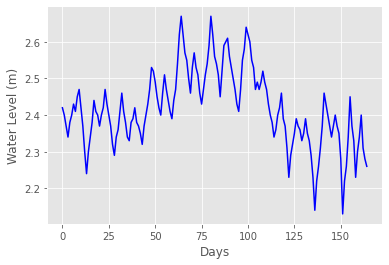

In [4]:
plt.plot(dataset1, color="blue")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')

plt.show()


In [5]:
# normalize the dataset1
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset1 = scaler.fit_transform(dataset1)


In [6]:
# split into train and test sets
train_size  = int(len(dataset1) * 0.67)
test_size   = len(dataset1) - train_size
train, test = dataset1[0:train_size,:], dataset1[train_size:len(dataset1),:]
print(len(train), len(test))


110 55


----------------- train data -----------------


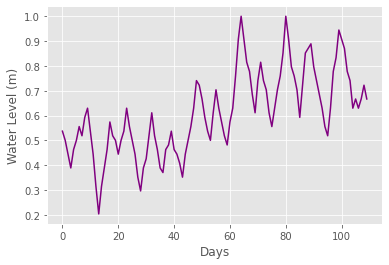

----------------- test data -----------------


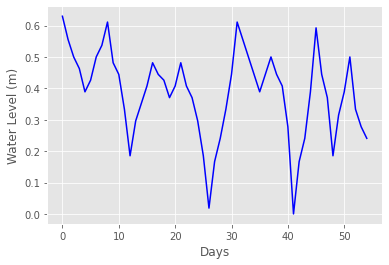

In [7]:
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- train data -----------------')
plt.plot(train, color="purple")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()

plt.show()
f, ax1 = plt.subplots(figsize=(6, 4))
print('----------------- test data -----------------')
plt.plot(test, color="blue")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()


In [8]:
# This function creates a sliding window of the dataset1.
def create_dataset1(dataset1, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset1)-sliding_window-1):
        a = dataset1[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset1[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)


In [9]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset1(train, slide_window)
testX, testY   = create_dataset1(test, slide_window)


In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [11]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',)
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2,)


Epoch 1/50
99/99 - 15s - loss: 0.1291
Epoch 2/50
99/99 - 0s - loss: 0.0195
Epoch 3/50
99/99 - 0s - loss: 0.0175
Epoch 4/50
99/99 - 0s - loss: 0.0172
Epoch 5/50
99/99 - 0s - loss: 0.0168
Epoch 6/50
99/99 - 0s - loss: 0.0162
Epoch 7/50
99/99 - 0s - loss: 0.0159
Epoch 8/50
99/99 - 0s - loss: 0.0152
Epoch 9/50
99/99 - 0s - loss: 0.0144
Epoch 10/50
99/99 - 0s - loss: 0.0148
Epoch 11/50
99/99 - 0s - loss: 0.0141
Epoch 12/50
99/99 - 0s - loss: 0.0136
Epoch 13/50
99/99 - 0s - loss: 0.0134
Epoch 14/50
99/99 - 0s - loss: 0.0128
Epoch 15/50
99/99 - 0s - loss: 0.0124
Epoch 16/50
99/99 - 0s - loss: 0.0118
Epoch 17/50
99/99 - 0s - loss: 0.0116
Epoch 18/50
99/99 - 0s - loss: 0.0110
Epoch 19/50
99/99 - 0s - loss: 0.0098
Epoch 20/50
99/99 - 0s - loss: 0.0115
Epoch 21/50
99/99 - 0s - loss: 0.0101
Epoch 22/50
99/99 - 0s - loss: 0.0096
Epoch 23/50
99/99 - 0s - loss: 0.0100
Epoch 24/50
99/99 - 0s - loss: 0.0092
Epoch 25/50
99/99 - 0s - loss: 0.0089
Epoch 26/50
99/99 - 0s - loss: 0.0085
Epoch 27/50
99/99 - 

In [12]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % testScore)




Train Score: 2.17 RMSE
Test Score: 2.19 RMSE


In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


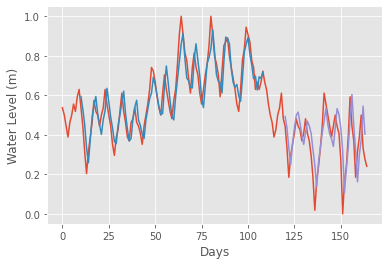

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict) + slide_window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (slide_window * 2) + 1:len(dataset1) - 1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset1)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()


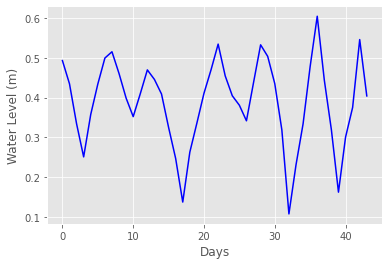

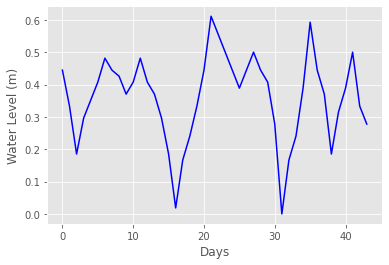

In [15]:
plt.plot(testPredict, color="blue")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()

plt.plot(testY, color="blue")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()


In [16]:
# Test the network on an unseen dataset1
unseen = pd.read_csv('dataset1/test1.csv',sep=',')


In [17]:
unseen.head()

,date,Water Level
0,20/02/2015,2.31
1,21/02/2015,2.33
2,22/02/2015,2.36
3,23/02/2015,2.32
4,24/02/2015,2.30


In [18]:
unseen_test = unseen['Water Level'].values



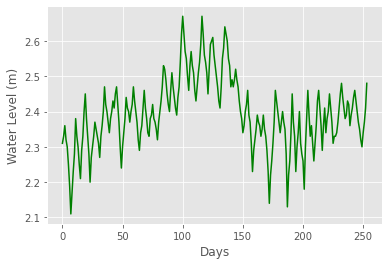

In [20]:
plt.plot(unseen_test[0:20000], color="green")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()


In [21]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)


In [22]:
features,labels = create_dataset1(unseen_clean, slide_window)
features        = np.reshape(features, 2430)



In [23]:
unseen_results = model.predict(testX)

-------------------- Model Prediction --------------------


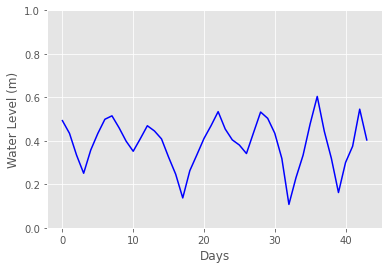

-------------------- Actual Measurement --------------------


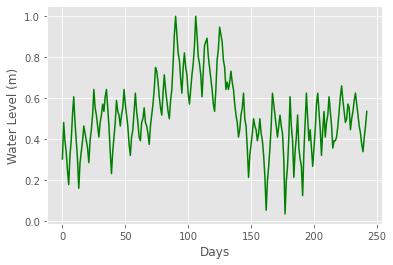

In [25]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Model Prediction --------------------')
plt.plot(unseen_results[0:20000], color="blue")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()


print('-------------------- Actual Measurement --------------------')
plt.plot(labels, color="green")
plt.xlabel('Days')
plt.ylabel('Water Level (m)')
plt.show()



The value of R-squared of water level is  0.02611589055188679


Text(0, 0.5, 'water level (m)')

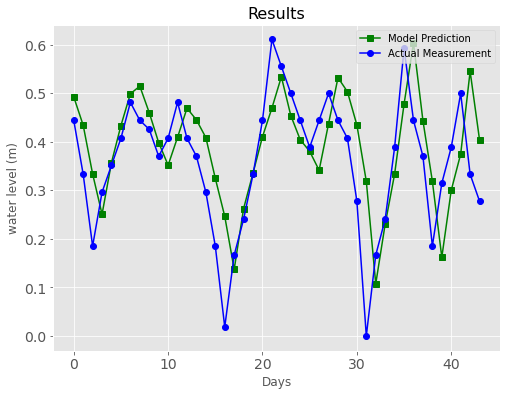

In [26]:

print('The value of R-squared of water level is ', r2_score(unseen_results, testY))

f, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(unseen_results, color="green", linestyle="-", marker="s", linewidth=1.5, label="Model Prediction")

plt.plot(testY, color="blue", linestyle="-", marker="o", linewidth=1.5, label="Actual Measurement")

ax1.set_title('Results', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Days')
plt.ylabel('water level (m)')

